<a href="https://colab.research.google.com/github/haleyrx/qe_project/blob/main/transquest_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prep**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/CS7643

/content/gdrive/MyDrive/CS7643


In [ ]:
# ! git clone https://2726c3be06d254f6092d9413236205338399aed0@github.com/haleyrx/qe_project

fatal: destination path 'qe_project' already exists and is not an empty directory.


In [5]:
!ls

colab_setup.ipynb  CS7643_HW4  qe_project


In [6]:
%cd qe_project
# ! git pull

/content/gdrive/MyDrive/CS7643/qe_project


In [7]:
!pip install sentencepiece
!pip install transformers==3


     |████████████████████████████████| 1.2MB 21.4MB/s 
     |████████████████████████████████| 757kB 19.6MB/s 
     |████████████████████████████████| 3.0MB 46.8MB/s 
     |████████████████████████████████| 901kB 49.2MB/s 


In [8]:
!nvidia-smi

Sat Apr 24 00:31:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
%pwd

'/content/gdrive/MyDrive/CS7643/qe_project'

In [10]:
import sys
sys.path.append('/content/gdrive/MyDrive/CS7643/qe_project/code')

### Set up parameters

In [11]:
SEED = 777
RESULT_FILE = 'en-de_result.tsv'
METRICS_FILE = 'en-de_metrics.txt'
BEST_MODEL_FILE = 'en-de_best_model.bin'
TRAIN_DATA = 'en-de/train.ende.df.short.tsv'
DEV_DATA = 'en-de/dev.ende.df.short.tsv'
TEST_DATA = 'en-de/test20.ende.df.short.tsv'
DATA_DIR = './data/'
OUTPUT_DIR = './results/'
BEST_MODEL_DIR = './best_models/'

# Model parameters
args = {
    'max_seq_length': 128,
    'train_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'eval_batch_size': 8,
    'num_train_epochs': 3,
    'weight_decay': 0,
    'learning_rate': 1e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.1,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,
    'dropout': 0.1
}

In [12]:
# Get relevant paths
import os 

train_path = os.path.join(DATA_DIR, TRAIN_DATA)
dev_path = os.path.join(DATA_DIR, DEV_DATA)
test_path = os.path.join(DATA_DIR, TEST_DATA)
best_model_path = os.path.join(BEST_MODEL_DIR, BEST_MODEL_FILE)
results_path = os.path.join(OUTPUT_DIR, RESULT_FILE)
metrics_path = os.path.join(OUTPUT_DIR, METRICS_FILE)


In [13]:
train_path

'./data/en-de/train.ende.df.short.tsv'

## Read in Data

In [14]:
from utils import read_file, fit, un_fit, get_metrics

df_train = read_file(train_path)
train = df_train[['original', 'translation', 'z_mean']]
train.head()

,original,translation,z_mean
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,1.119409
1,"However, a disappointing ninth in China meant ...",Eine enttäuschende Neunte in China bedeutete j...,-0.488591
2,"In his diary, Chase wrote that the release of ...","In seinem Tagebuch, Chase schrieb, dass die Ve...",-2.207007
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,-0.799946
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,0.381633


In [15]:
# df_dev = pd.read_csv(dev_path,sep='\t')
df_dev = read_file(dev_path)
dev = df_dev[['original', 'translation', 'z_mean']]
dev.head()

,original,translation,z_mean
0,"Simultaneously, the Legion took part to the pa...",Gleichzeitig nahm die Legion an der Befriedung...,-0.312186
1,He also begins an affair with Veronica Harring...,Er beginnt auch eine Affäre mit Veronica Harri...,-0.401581
2,The urban morphology of these two local waters...,Die urbane Morphologie dieser beiden lokalen W...,0.275414
3,Important finds included a bronze axe in Wellw...,Wichtige Funde waren eine Bronzeaxt in Wellwoo...,0.580925
4,"Previously, Englishmen had drunk mainly dark s...",Früher hatten Engländer vor allem dunkle Stout...,-1.895129


In [16]:
# df_test = pd.read_csv(test_path,sep='\t')
df_test = read_file(test_path)
test = df_test[['original', 'translation', 'z_mean']]
test.head()

,original,translation,z_mean
0,"The Sultan appoints judges, and can grant pard...",Der Sultan ernennt Richter und kann Begnadigun...,0.349371
1,Antisemitism in modern Ukraine Antisemitism an...,Antisemitismus in der modernen Ukraine Antisem...,0.392435
2,"Morales continued his feud with Buddy Rose, de...",Morales setzte seine Fehde mit Buddy Rose fort...,0.645034
3,American Maury Tripp attended the Jamboree fro...,Der Amerikaner Maury Tripp besuchte das Jambor...,0.544519
4,He bowled a series of bouncers at Viv Richards...,Er boomte eine Reihe von Bouncern bei Viv Rich...,-0.589531


In [17]:
train = train.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
dev = dev.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
test = test.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()

In [18]:
# Normalize scores to be between 0 and 1
train = fit(train, 'labels')
dev = fit(dev, 'labels')

### Import packages

In [19]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaModel
import torch

import numpy as np
import pandas as pd
# from pylab import rcParams
import matplotlib.pyplot as plt
# from matplotlib import rc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from collections import defaultdict
# from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [20]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Download pretrained model

In [21]:
# Initialize config, tokenizer, and pretrained model
MODEL_CLASSES = {'xlmroberta': (XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer)}
MODEL_TYPE = 'xlmroberta'
MODEL_NAME = 'xlm-roberta-large'

config_class, model_class, tokenizer_class = MODEL_CLASSES[MODEL_TYPE]

config = config_class.from_pretrained(MODEL_NAME, num_labels=1, hidden_dropout_prob=args['dropout'])
# config = config_class.from_pretrained(MODEL_NAME, num_labels=1)
tokenizer = tokenizer_class.from_pretrained(MODEL_NAME)

In [22]:
config

XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

### Create data loader and load batches

In [23]:
class TranslationDataset(Dataset):
  def __init__(self, text_a, text_b, labels, tokenizer, max_len):
    self.text_a = text_a
    self.text_b = text_b
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text_a)

  def __getitem__(self, item):
    original = str(self.text_a[item])
    translation = str(self.text_b[item])
    label = float(self.labels[item])
    encoding = self.tokenizer.encode_plus(
      original,
      translation,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'original_text': original,
      'translation_text': translation,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.float32)
    }

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TranslationDataset(
    text_a=df.text_a.to_numpy(),
    text_b=df.text_b.to_numpy(),
    labels=df.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [25]:
train_data_loader = create_data_loader(train, tokenizer, args['max_seq_length'], args['train_batch_size'])
dev_data_loader = create_data_loader(dev, tokenizer, args['max_seq_length'], args['train_batch_size'])
test_data_loader = create_data_loader(test, tokenizer, args['max_seq_length'], args['train_batch_size'])

In [26]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['original_text', 'translation_text', 'input_ids', 'attention_mask', 'label'])

In [27]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


In [28]:
print(data['original_text'][0])
print(data['label'][0].numpy())

José Ortega y Gasset visited Husserl at Freiburg in 1934.
0.8421048


### Define MonoTransQuest Model

In [29]:
class MonoTransQuest(nn.Module):

  def __init__(self, config):
    super(MonoTransQuest, self).__init__()
    self.model = XLMRobertaModel.from_pretrained('xlm-roberta-large')
    self.dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = outputs[0]
    x = sequence_output[:, 0, :]  # take <s> token (equiv. to [CLS])
    x = self.dropout(x)
    x = self.dense(x)
    x = torch.tanh(x)
    x = self.dropout(x)
    x = self.out_proj(x)

    return torch.sigmoid(x)

In [30]:
model = MonoTransQuest(config)
model = model.to(device)

### Training

In [31]:
import math

t_total = len(train_data_loader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
warmup_steps = math.ceil(t_total * args['warmup_ratio'])
args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']

optimizer = AdamW(model.parameters(), lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=args['warmup_steps'], 
  num_training_steps=t_total
)

loss_fn = nn.MSELoss().to(device)

In [32]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = torch.unsqueeze(d["label"], 1)
    labels = labels.float()
    labels = labels.to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=args['max_grad_norm'])
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return np.mean(losses)

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      loss = loss_fn(outputs, labels)
      losses.append(loss.item())
  return np.mean(losses)

In [34]:
%%time

history = defaultdict(list)
best_loss = float('inf')
for epoch in range(args['num_train_epochs']):
  print(f'Epoch {epoch + 1}/{args["num_train_epochs"]}')
  print('-' * 10)
  train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss}')
  val_loss = eval_model(
    model,
    dev_data_loader,
    loss_fn,
    device,
    len(df_dev)
  )
  print(f'Val   loss {val_loss}')
  print()
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  if val_loss < best_loss:
    # torch.save(model.state_dict(), best_model_path)
    best_loss = val_loss

Epoch 1/3
----------
Train loss 0.011108124872436747
Val   loss 0.02185358040034771

Epoch 2/3
----------
Train loss 0.007191898816032335
Val   loss 0.01655806286633015

Epoch 3/3
----------
Train loss 0.006734433658944909
Val   loss 0.014824635073542595

CPU times: user 18min 46s, sys: 17min 37s, total: 36min 23s
Wall time: 36min 24s


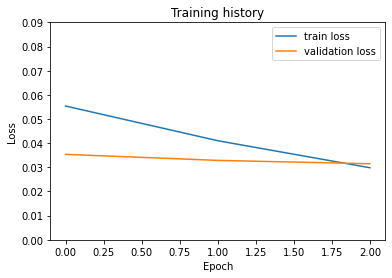

In [ ]:
# Plot graphs 
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.09]);

### Generating predictions and metrics

In [ ]:
# Load pretrained model
model = MonoTransQuest(config)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

In [35]:
# Function to calculate predictions on test set
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  originals = []
  translations = []

  with torch.no_grad():
    for d in data_loader:
      ori = d["original_text"]
      trans = d["translation_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      preds = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      originals.extend(ori)
      translations.extend(trans)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return originals, translations, predictions, real_values

In [36]:
# Get predictions 
originals, translations, predictions, real_values = get_predictions(model, test_data_loader)

preds = predictions.numpy().squeeze()
labels = real_values.numpy().squeeze()
original = np.array(originals)
translation = np.array(translations)

df_results = pd.DataFrame()
df_results['original'] = original
df_results['translation'] = translation
df_results['z_mean'] = labels
df_results['pred_zscore'] = preds

df_results = un_fit(df_results, 'pred_zscore')

df_results.head(30)

,original,translation,z_mean,pred_zscore
0,"The Sultan appoints judges, and can grant pard...",Der Sultan ernennt Richter und kann Begnadigun...,0.349371,-0.180513
1,Antisemitism in modern Ukraine Antisemitism an...,Antisemitismus in der modernen Ukraine Antisem...,0.392435,-0.240227
2,"Morales continued his feud with Buddy Rose, de...",Morales setzte seine Fehde mit Buddy Rose fort...,0.645034,-0.285555
3,American Maury Tripp attended the Jamboree fro...,Der Amerikaner Maury Tripp besuchte das Jambor...,0.544519,-0.204697
4,He bowled a series of bouncers at Viv Richards...,Er boomte eine Reihe von Bouncern bei Viv Rich...,-0.589531,-0.394623
5,The Frenchwoman's win irritated some of her ma...,Der Sieg der Französin irritierte einige ihrer...,0.545212,-0.244608
6,"Good or bad, the theories of educators such as...","Gut oder schlecht, die Theorien der Pädagogen ...",0.482552,-0.322643
7,Alfred Stieglitz enrolled in the Real Gymnasiu...,Alfred Stieglitz hat sich am Real Gymnasium Ka...,0.527603,-0.117829
8,Superman battles the Phantom Zone villains in ...,Superman kämpft gegen die Schurken der Phantom...,0.572117,-0.178461
9,"However, Berke remained neutral militarily, an...",Berke blieb jedoch militärisch neutral und tra...,0.144321,-0.306057


In [38]:
filename = 'en-de_lr'+str(args['learning_rate'])+'_d'+str(args['dropout'])+'.txt'
output_path = os.path.join(OUTPUT_DIR, filename)
get_metrics(df_results, output_path=output_path, dropout=args['dropout'], lr=args['learning_rate'])

Pearson: 0.39480906256986
RMSE: 0.7341931840012408
MAE: 0.6038007483245742


In [ ]:
# Save predictions to tsv
df_results.to_csv(results_path, sep = '\t', index=False)